# Initialisation

In [1]:
# Installation des dépendances
# !sudo apt-get update
# !sudo apt-get install ffmpeg libsm6 libxext6  -y
# !pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/segment-anything.git
# !pip install opencv-python ipympl

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-105hod7r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-105hod7r
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [2]:
from utils.download import download_file
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from segment_anything import sam_model_registry

# Chargement du modèle Segment Anything

# Je choisis le modèle 'léger'
sam_checkpoint = str(download_file('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'))
model_type = "vit_b"

# sam_checkpoint = str(download_file('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'))
# model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Utilisation du GPU
sam = sam.to(device="cuda")

In [3]:
def display_masks(image, masks, max_masks=14, max_columns=5):
    '''Fonction pour afficher une image et sa décomposition en masques
    dans plusieurs sous-figures'''
    # Je vais afficher des sous images
    # Nombre de sous-images qui seront présentées
    nb_masks = min(masks.shape[0],max_masks)
    # Ceci permet d'initialiser les sous-figures
    nb_colonnes= min(nb_masks+1,max_columns)
    nb_rows = ceil((nb_masks+1)/nb_colonnes)
    fig, axs =plt.subplots(
        nrows=nb_rows,
        ncols=nb_colonnes,
        squeeze=False,
        figsize=(nb_colonnes*3,nb_rows*3),
        layout='compressed')
    # On masque les axes des sous-figures
    for ax in axs.flatten():
        ax.axis('off')
    # La première vignette présente l'image initiale
    axs[0,0].imshow(image)
    # Puis je présente les découpages dans les sous-figures suivantes
    for i in range(nb_masks):
        img = np.copy(image)
        # La partie extérieure à la zone d'intérêt est blanche
        img[~masks[i]] = 255
        axs[(i+1)//nb_colonnes,(i+1)%nb_colonnes].imshow(img)


# Image à charger

(-0.5, 639.5, 479.5, -0.5)

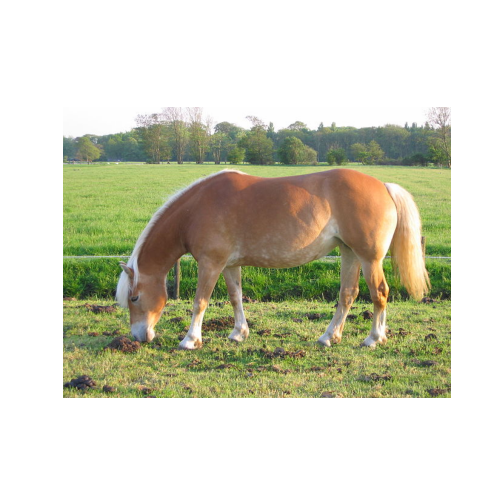

In [4]:
img_path = download_file("https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Haflinger_horse_on_pasture_in_the_Netherlands.jpg/640px-Haflinger_horse_on_pasture_in_the_Netherlands.jpg")

image = cv2.imread(str(img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.close('all')
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')

# Segmentation à partir d'un point de l'image
Ici, je choisis un point donné sur l'image (le milieu dans notre cas), et je lui demande d'isoler la zone correspondante.

In [5]:
# Initialisation du prédicteur, avec l'image que l'on veut analyser
from segment_anything import SamPredictor
predictor = SamPredictor(sam)
predictor.set_image(image)

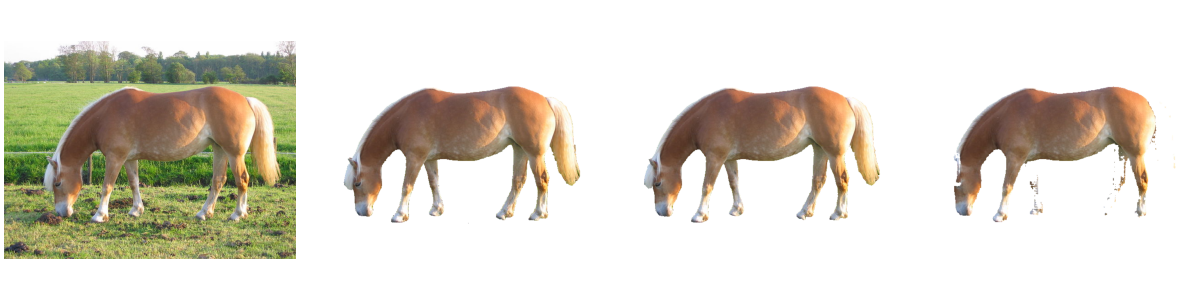

In [6]:
# On va se concentrer sur le point central de l'image
input_point = np.array([[image.shape[1]//2,image.shape[0]//2]])
# et indiquer que c'est un avant-plan (1)
input_label = np.array([1])

# on obtient alors les masques prédits pour ce point
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
display_masks(image,masks)

## Segmentation automatique
Ici, on laisse l'outil segmenter lui-même toute l'image. On note qu'on ne retrouve pas forcément l'élément principal de l'image avec le modèle "vit_b".

In [7]:
# Génération des masques
from segment_anything import SamAutomaticMaskGenerator
mask_generator  = SamAutomaticMaskGenerator(sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,)
auto_masks = mask_generator.generate(image)

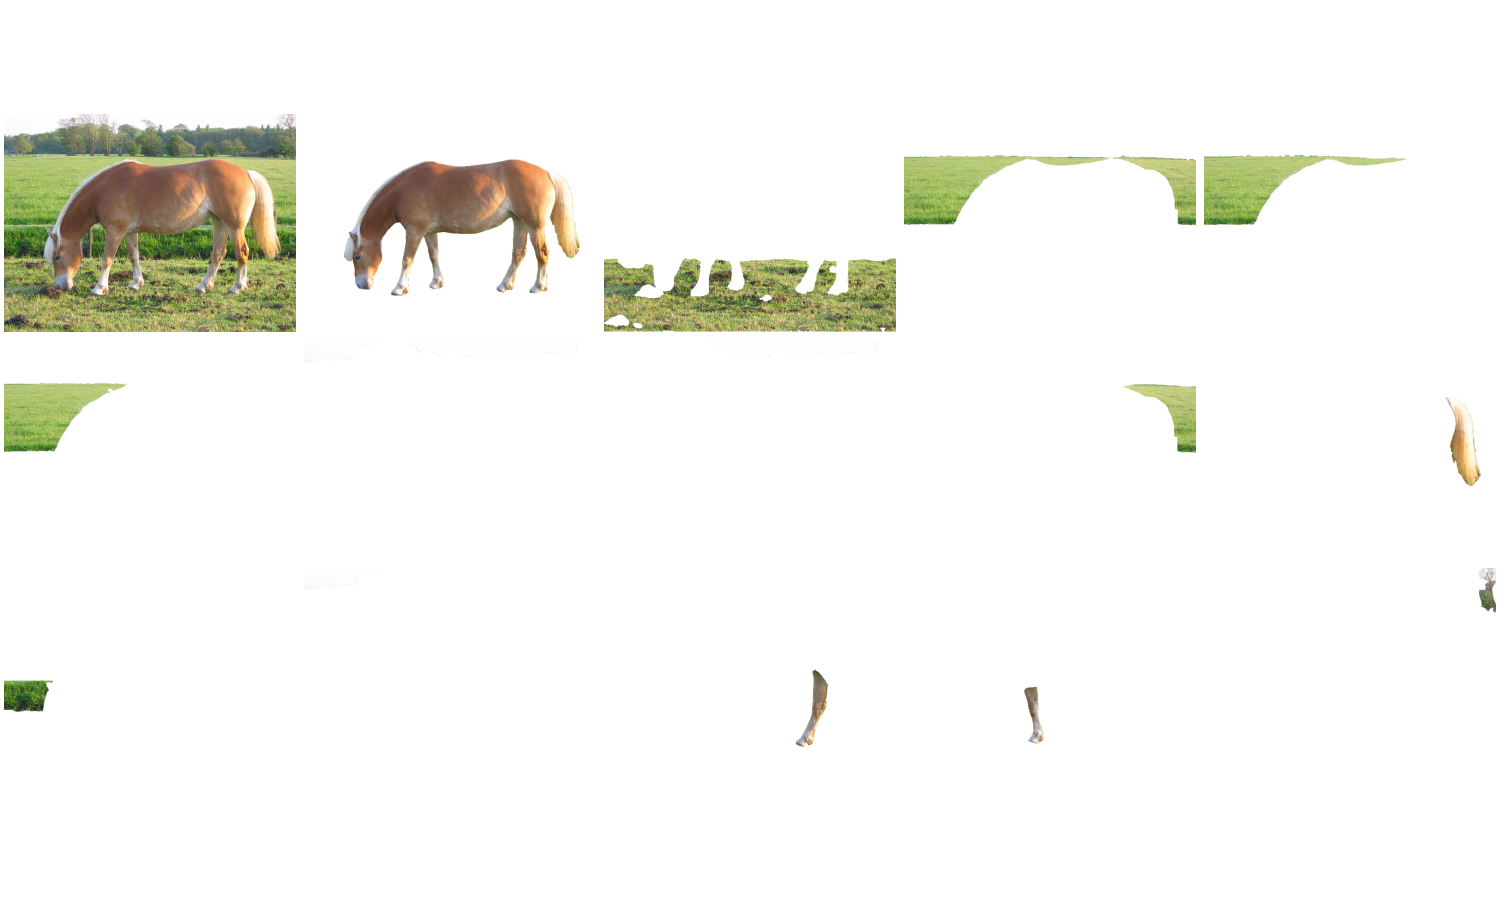

In [8]:
# Je trie les segmentation dans l'ordre décroissant des surfaces
auto_masks_sorted = sorted(auto_masks, key=lambda x:x['area'],reverse=True)
masks = np.array([auto_mask["segmentation"] for auto_mask in auto_masks_sorted])
# et j'affiche les découpages
display_masks(image,masks)